# Data Exploration and Multivariable Analysis

This notebook will explore different exploration tools in order to determine that the data at hand is adequate for what we plan to use it -- in this case, a classification of the presence of organized crime in a given Mexican state from 2010 to 2016.

First, I'll read in the data we've been working with and impute with zero (which is the same as median imputation in our case), since it's what seemed to make the most sense from the previous notebook.

In [1]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import importlib
importlib.reload(mdc)
importlib.reload(epc)

<module 'exploration_pca_ca' from '/Users/mariomoreno/Desktop/ML Projects/Mexico OC/exploration_pca_ca.py'>

In [2]:
# Reading in data
df = mdc.reading_in('data/Mexico_Final.xlsx')

In [3]:
mdc.impute_zero(df, {'costa_km':0}).head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios,pop
0,Aguascalientes,2010,40129,19250,20879,2727,144,2698,3239,325,...,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11,1195787
1,Baja California,2010,107624,53692,53932,6192,271,2342,9353,3241,...,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5,3224843
2,Baja California Sur,2010,23247,11780,11467,1588,76,1255,1660,296,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5,649616
3,Campeche,2010,28350,14349,14001,1975,106,3373,1179,144,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11,836747
4,Coahuila de Zaragoza,2010,82553,41397,41156,6219,330,23331,7867,545,...,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38,2782012


In [4]:
cols = mdc.find_missing_cols(df)

In [5]:
# loop to pull out the missing columns from the list above# loop t 
cols_impute = []
for c in cols:
    cols_impute.append(c[0])

In [6]:
working_df = mdc.single_imputation(df, 'median', cols_impute)

### 1) Quick Data Exploration 

Part of the analysis is determining certain components of our data, which means doing a quick exploration of how different columns and states relate to each other. This will hopefully uncover outliers, highly correlated variables, and other worthwhile findings. Once this is done, we'll move on to the next step which is a quick standardization of the variables and then PCA and Cluster Analysis


Summary stats for entidad
count                           224
unique                           32
top       Quintana Roo             
freq                              7
Name: entidad, dtype: object


Summary stats for year
count     224.000000
mean     2013.000000
std         2.004479
min      2010.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2016.000000
Name: year, dtype: float64


Summary stats for alumnos_inscritos_hs
count       224.000000
mean     139023.571429
std      116544.209387
min       23247.000000
25%       62133.250000
50%      108420.500000
75%      158046.250000
max      640965.000000
Name: alumnos_inscritos_hs, dtype: float64


Summary stats for hombres_inscritos_hs
count       224.000000
mean      69030.053571
std       57721.462175
min       11567.000000
25%       30118.750000
50%       54462.000000
75%       78666.500000
max      314509.000000
Name: hombres_inscritos_hs, dtype: float64


Summary stats for mujeres_inscritas_hs
cou

Summary stats for prod_fierropellets_t
count    2.240000e+02
mean     1.277380e+06
std      1.711222e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.489120e+06
max      3.944485e+06
Name: prod_fierropellets_t, dtype: float64


Summary stats for prod_azufre_t
count       224.000000
mean      29073.022321
std       74241.298164
min           0.000000
25%           0.000000
50%           0.000000
75%        3604.750000
max      417166.000000
Name: prod_azufre_t, dtype: float64


Summary stats for prod_barita_t
count       224.000000
mean       4134.375000
std       18791.281828
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      119964.000000
Name: prod_barita_t, dtype: float64


Summary stats for prod_fluorita_t
count    2.240000e+02
mean     3.174360e+04
std      1.681754e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.150234e+06
Name: prod_fluorita_t,

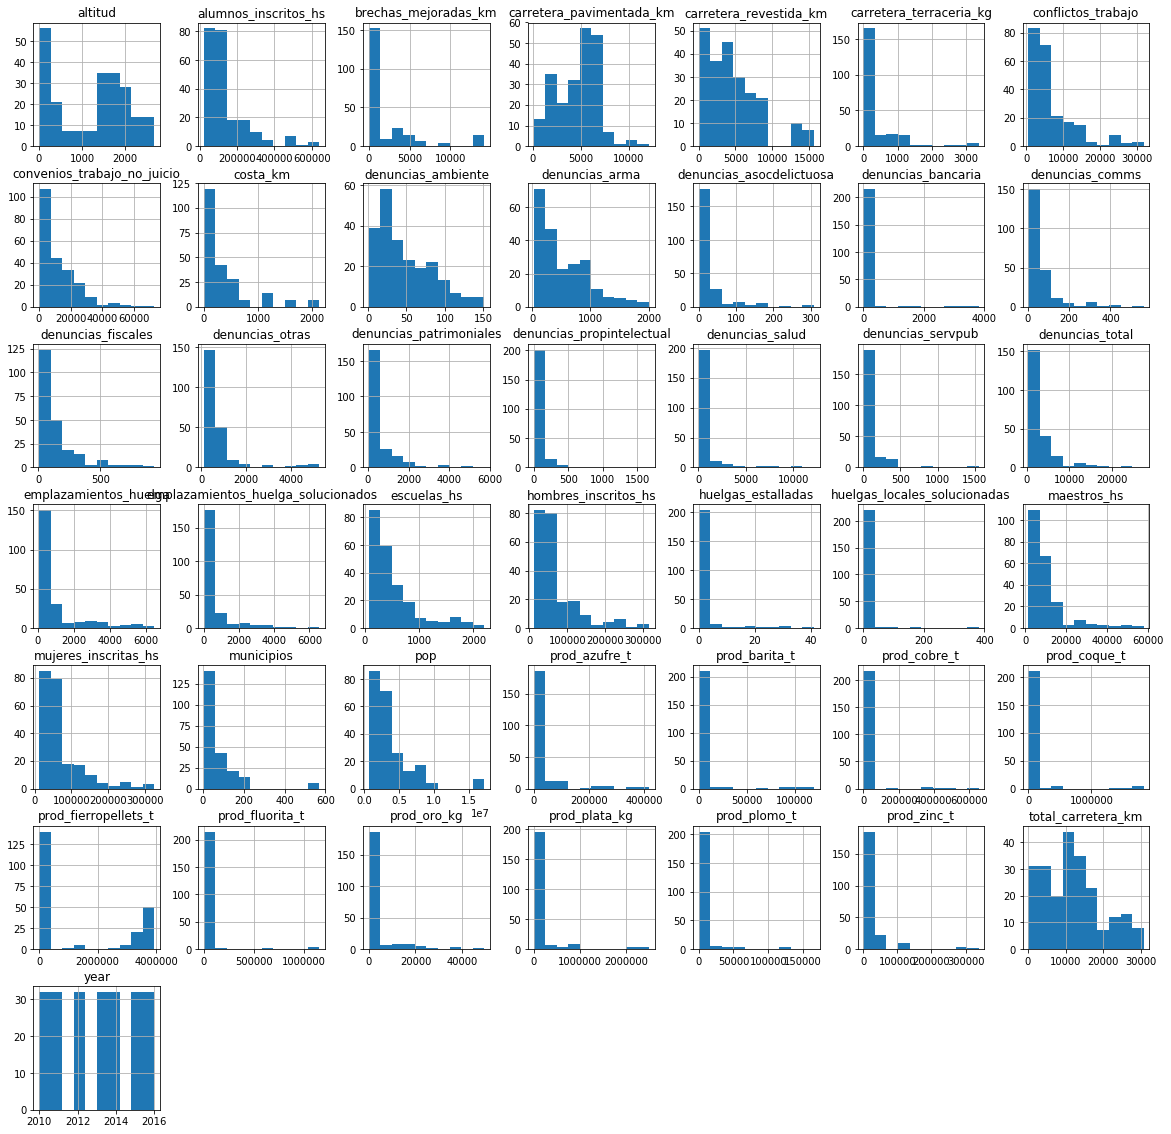

In [7]:
epc.explore_data(working_df)

Not that much to note from the histograms or descriptive statistics. I'll dive a little deeper in to outliers, as there are appears to be some...but that might be a function of the disparate populations within states and the large number of population dependent variables.

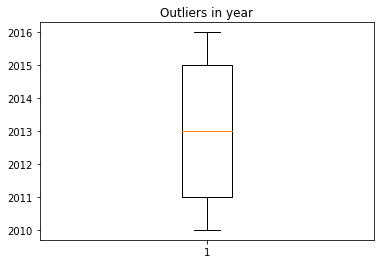

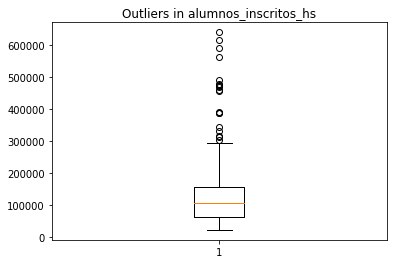

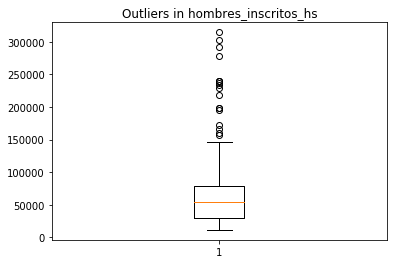

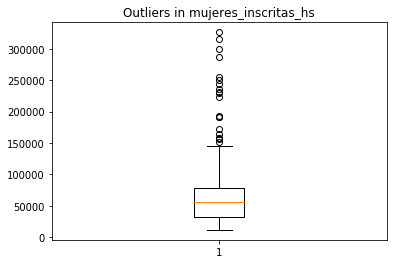

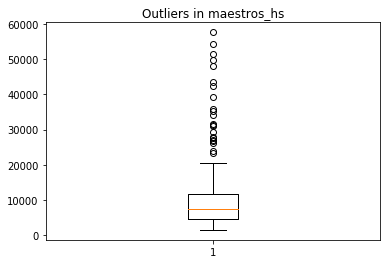

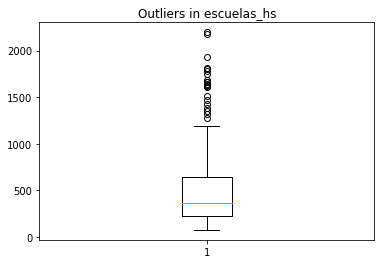

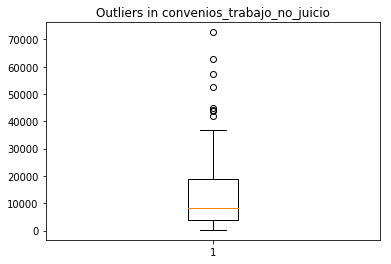

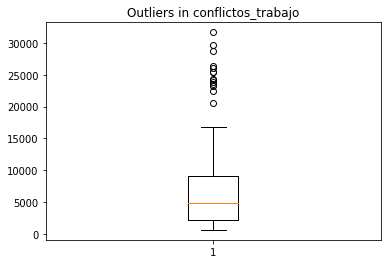

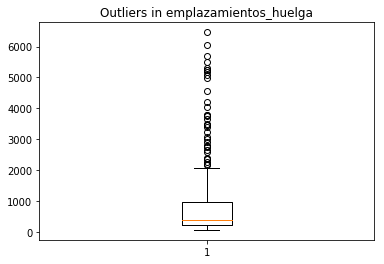

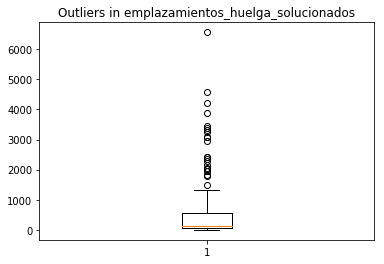

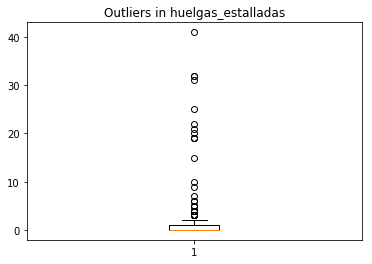

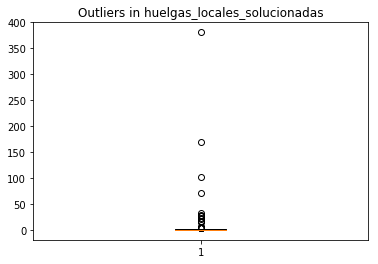

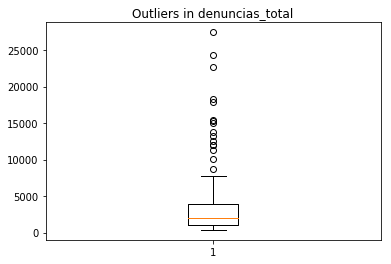

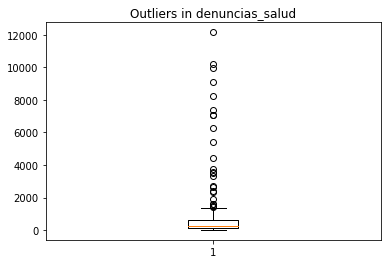

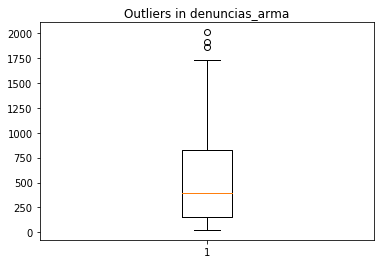

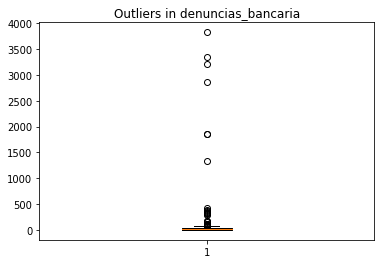

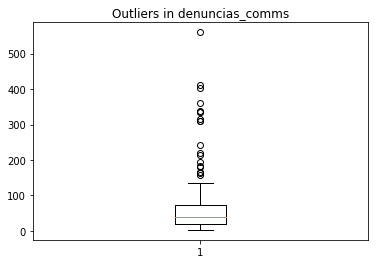

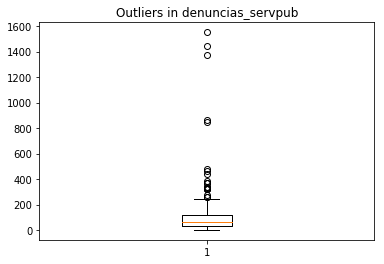

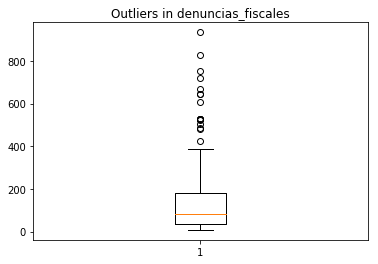

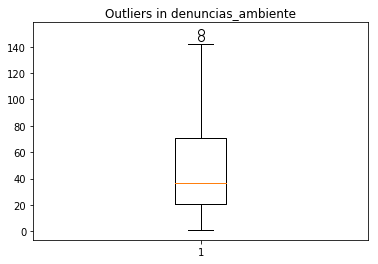

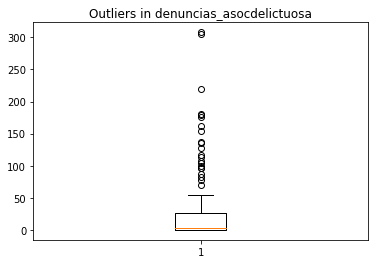

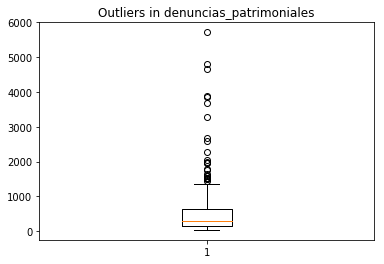

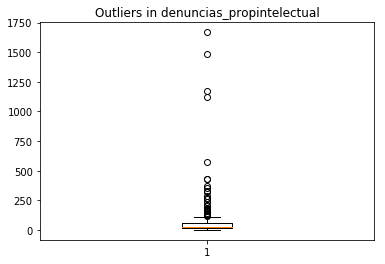

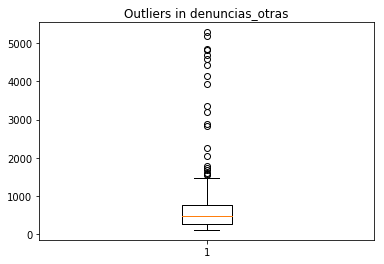

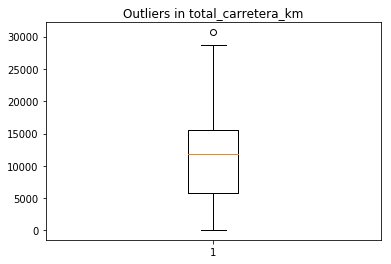

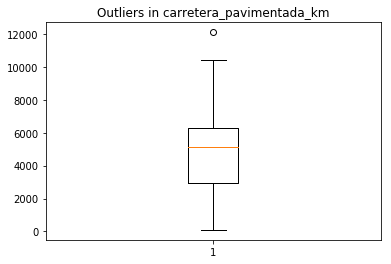

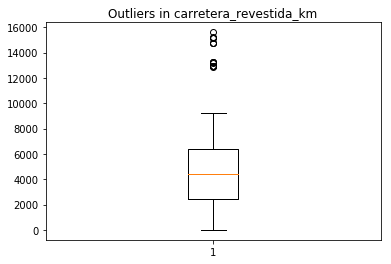

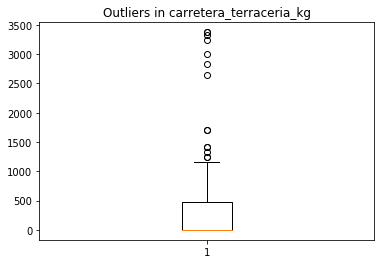

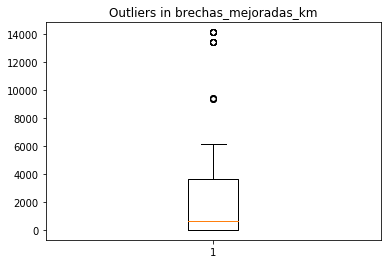

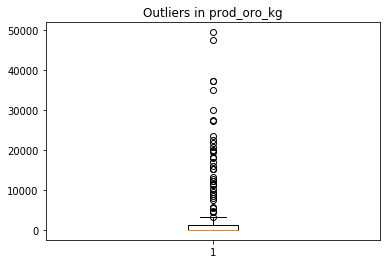

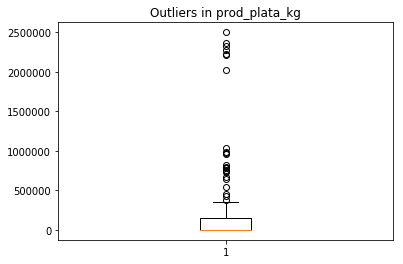

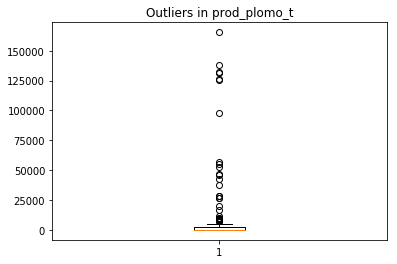

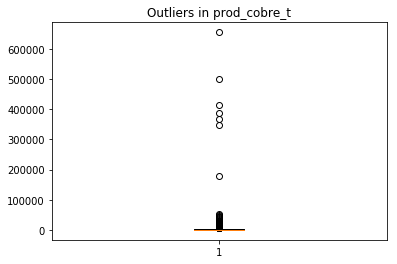

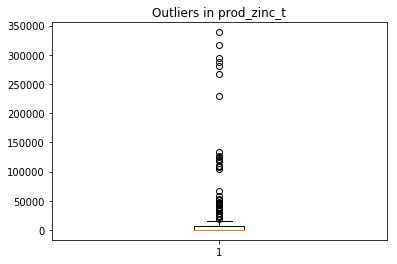

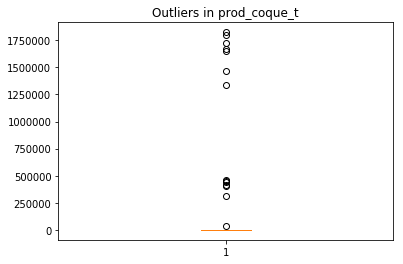

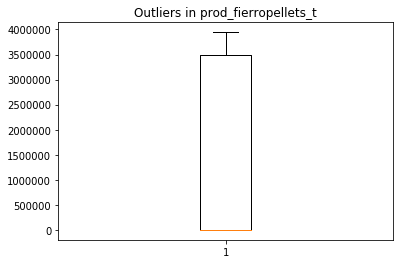

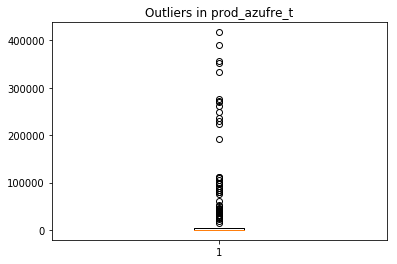

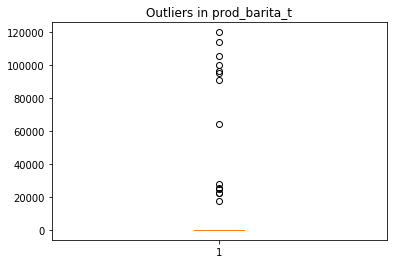

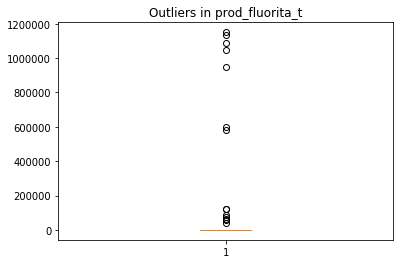

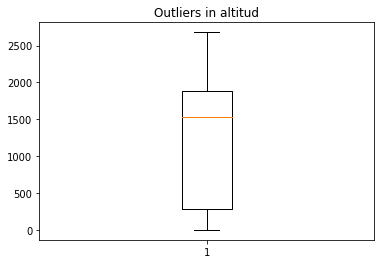

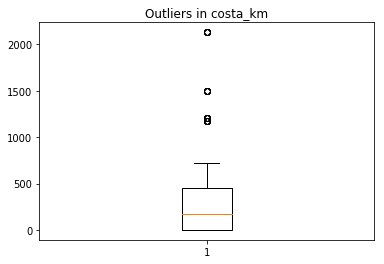

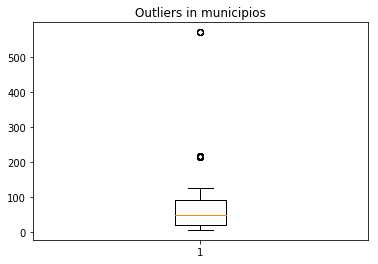

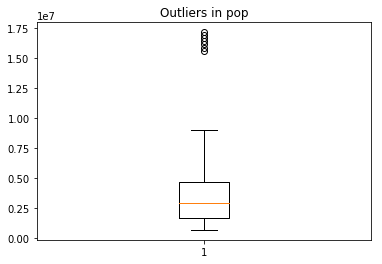

In [8]:
epc.box_plot(working_df)

Most variables have outliers, but I can generally group the variables with outliers in two: population dependent variables and metal production variables. 

Given that a lot of Mexican states are more populous than others and some states have the natural resources to produce metals, the outliers make sense and might not be indicative of flawed data. To be extra sure, I think it would be appropriate to convert all the population dependent variables to per capita and, after the PCA and Cluster Analysis, likely discretize. I'll drop the population variable after the per capita change.

Thankfully, our population dependent columns are all in order between indexes 2-24. It should be pretty straightforward dividing them by population.

In [9]:
# per capita calculation
working_df.iloc[:,2:24] = working_df.iloc[:,2:24].div(working_df.iloc[:,-1], axis=0)
del working_df['pop']
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,0.033559,0.016098,0.017460,0.002281,0.000120,0.002256,0.002709,0.000272,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,0.033373,0.016649,0.016724,0.001920,0.000084,0.000726,0.002900,0.001005,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,0.035786,0.018134,0.017652,0.002445,0.000117,0.001932,0.002555,0.000456,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,0.033881,0.017149,0.016733,0.002360,0.000127,0.004031,0.001409,0.000172,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,0.029674,0.014880,0.014794,0.002235,0.000119,0.008386,0.002828,0.000196,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


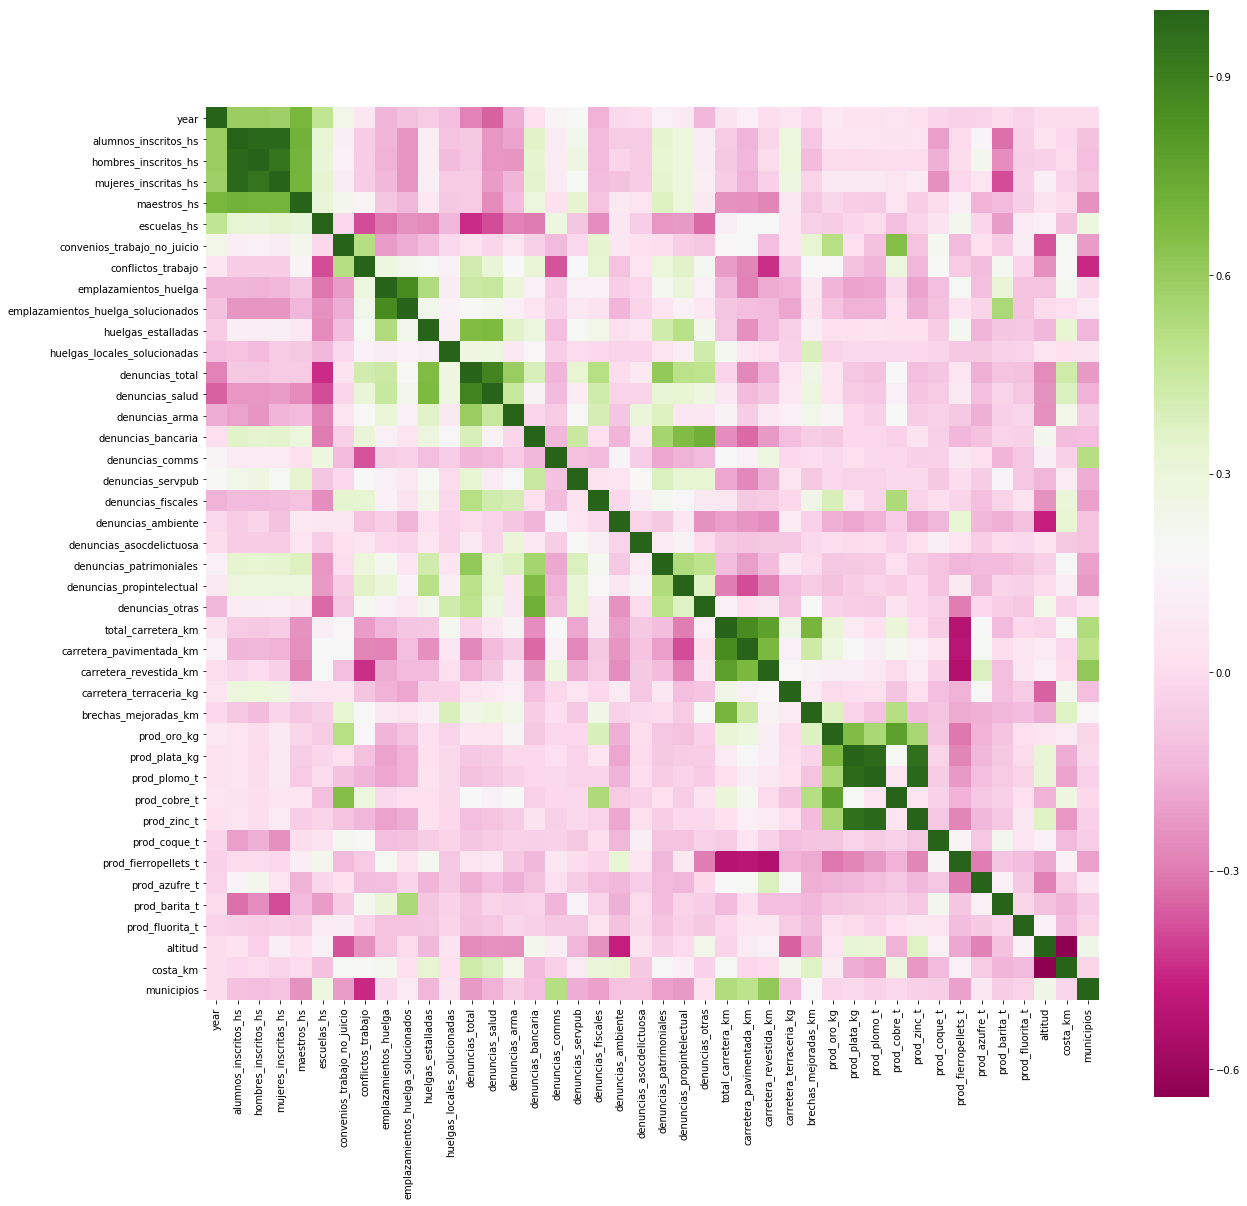

In [10]:
epc.explore_potential_correlations(working_df)

A couple of things to note from the correlation heatmap:
- There's significant correlation between all the education variables, so we'd expect them to group together in a Principal Components Analysis
- There's generally a positive correlation between several of the denuncias variables, so we'd expect them to once again group together under a Principal Component Analysis. We'd also expect the carretera variables to group together.
- There's positive correlation between the production of different metals variables, but only among the more common ones like gold, silver, copper, which is interesting to say the least. Curious to see if the group together in PCA or not.

### 2) Principal Components Analysis 

The first step in doing this analysis is standardizing all the variables, which is different than normalizing theoretically and functionally. This is necessary since a lot of machine learning algorithms, PCA included, are optimized for standardized variables -- or variables that have the same units across them. 
- Theoretically, standardizing transforms the variables onto the unit scale (mean = 0, variance = 1) which measures how variables are distributed from the mean. Functionally, I'm only doing this to implement the PCA algorithm which requires it. I'll keep working_df intact for the next step, which is normalization.
- Theoretically, normalizing transforms the variables into the same units, and standardization is an option in normalizing but not the only one. You can normalize by rank, z-score, and more. Functionally, I'll do that in the next step.

First I'll need to re-index everything to have state and year as index

In [11]:
new = working_df.set_index(['entidad', 'year'])
new.head()

,,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
entidad,year,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,2010,0.033559,0.016098,0.017460,0.002281,0.000120,0.002256,0.002709,0.000272,0.000163,0.000000,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
Baja California,2010,0.033373,0.016649,0.016724,0.001920,0.000084,0.000726,0.002900,0.001005,0.000313,0.000010,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
Baja California Sur,2010,0.035786,0.018134,0.017652,0.002445,0.000117,0.001932,0.002555,0.000456,0.000196,0.000002,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
Campeche,2010,0.033881,0.017149,0.016733,0.002360,0.000127,0.004031,0.001409,0.000172,0.000012,0.000000,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
Coahuila de Zaragoza,2010,0.029674,0.014880,0.014794,0.002235,0.000119,0.008386,0.002828,0.000196,0.000037,0.000000,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


In [12]:
standardized = epc.standardize(new)
standardized

array([[-0.87069888, -1.03345168, -0.65959919, ...,  0.75668599,
        -0.68966787, -0.63639405],
       [-0.9090159 , -0.82101562, -0.97766916, ..., -1.40201173,
         2.27289033, -0.69424805],
       [-0.41003206, -0.24906994, -0.5769029 , ..., -1.39391806,
         3.53887301, -0.69424805],
       ..., 
       [ 0.98429507,  0.96798662,  0.97012237, ...,  0.28262811,
         0.73902731,  1.3017151 ],
       [ 0.91065262,  0.95010674,  0.83641521, ..., -1.3950743 ,
        -0.01500626,  0.27962769],
       [ 1.01749177,  0.62594033,  1.42275525, ...,  1.41574207,
        -0.68966787, -0.18320435]])

In [13]:
yn = epc.pca(standardized, 2)

Variance explained for first 2 components:
[ 0.15317816  0.12180898]


This is a fairly weak Principal Component Analysis -- reducing the dimensionality to two columsn only helps explain about 37% of the variance. This means that there's likely an issue with our original data.

In [14]:
import pandas as pd
principalDF = pd.DataFrame(data = yn, columns = ['PC1', 'PC2'])
principalDF.head()

,PC1,PC2
0,0.182111,-0.046460
1,10.241226,-4.640748
2,3.429386,-0.463209
3,0.051744,-0.065339
4,-1.200888,-2.025912


In [15]:
final = pd.concat([principalDF, working_df['entidad'], working_df['year']],  axis=1)

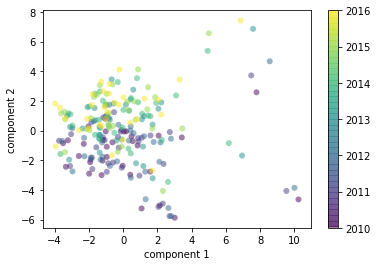

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(final.iloc[:, 0], final.iloc[:, 1],
            c=final.iloc[:,3], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

There doesn't seem to be much difference between the years in terms of components, which is to be expected. 

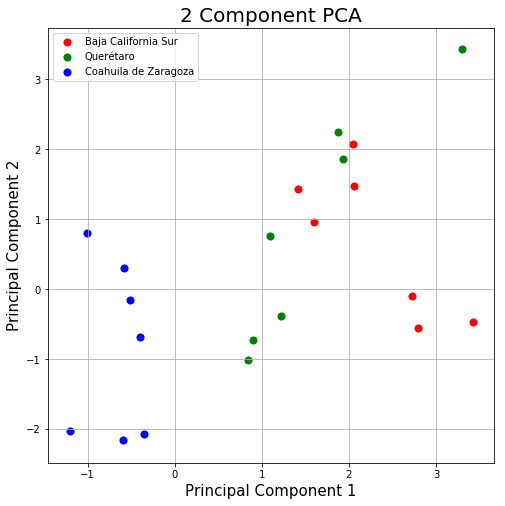

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Baja California Sur', 'Querétaro', 'Coahuila de Zaragoza']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final['entidad'] == target
    ax.scatter(final.loc[indicesToKeep, 'PC1']
               , final.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

It's a test graph, but there appears to be some decent division between the states as it relates to the principal component analysis. I do need to do some cleaning up here in order to get all the states graphed. I think next step is to do a jaro winkler comparison in order to get all the states graphed and expand the color map options.

From there, bar graph of PCA variance explanation and one that breaks it down into components before moving on to cluster analysis.

### 3) Cluster Analysis

There's a whole range of clustering algorithms that could work in this scenario, but I'll use affinity propagation here because it creates clusters between pairs of samples until convergence. It describes a dataset using a small number of examples which it identifies as representative of the other samples -- and it does this iteratively.

We'll work from our previously standardized dataset

In [32]:
from sklearn import cluster, covariance, manifold


# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = new.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(working_df.iloc[:,0].values[labels == i])))

/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


Cluster 1: Aguascalientes           
Cluster 2: Baja California          
Cluster 3: Baja California Sur
Cluster 4: Campeche                 
Cluster 5: Colima                   
Cluster 6: Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo
Cluster 7: Morelos                  
Cluster 8: Nayarit                  
Cluster 9: Puebla                   
Cluster 10: San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí
Cluster 11: Sonora                   , Sonora                   
Cluster 12: Tlaxcala                 
Cluster 13: Yucatán                  
Cluster 14: Aguascalientes           
Cluster 15: Baja California          
Cluster 16: Baja California Sur
Cluster 17: Campeche                 
Cluster 18: Colima                   
Cluster 19: Guanajuato               , Guanajuato               , Oaxaca                   , Guanajuato               


Pretty strange results in the sense that it made some clusters that make perfect sense (Clusters 51, 65, 66) for example are all composed of the same state for different years which makes s ense. Yet, states like Colima and Campeche are grouped into seven different clusters. There's definitely something off with this data.